<a href="https://colab.research.google.com/github/FelipeFerAl/SignalsTheory/blob/main/RedParaAudios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Librerias

In [ ]:
from IPython.display import clear_output, Audio
from google.colab import drive
from scipy.signal import welch, butter, filtfilt, spectrogram
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import librosa
import sys

sys.setrecursionlimit(1300)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#Funciones

In [ ]:
#@title Carga de datos
def carga():
  """
  Realiza la creación de los archivos a trabajar
  Entrada: None
  Salida: Etiquetas de los audios, matriz de audios, frecuencia de muestreo
  """
  base = '/content/drive/MyDrive/Radios_etiquetados.xlsx'
  df = pd.read_excel(base)

  audio_folder = '/content/drive/MyDrive/ANEaudios.zip'
  with zipfile.ZipFile(audio_folder,'r') as zip_ref:
    zip_ref.extractall('/content/ANEaudios')

  audios = []
  for i in range(len(df)):
    filename = df.loc[i,'Audio']
    if filename in os.listdir('/content/ANEaudios/'):
      archivo = os.path.join('/content/ANEaudios',filename)
      y, fr = librosa.load(archivo,sr=44100)
      audios.append(y)

  M_audios = np.array(audios)
  return df, M_audios, fr

def carga2():
  """
  Transformada de las señales a PSD dependiendo su etiqueta y promediando
  Entrada: None
  Salida: Promedio de las transformaciones en base a la etiqueta
  """
  etiquetas = '/content/drive/MyDrive/Radios_etiquetados.xlsx'
  df = pd.read_excel(etiquetas)
  audios_0 = []
  audios_1 = []

  for i in range(len(df)):
    filename = df.loc[i,'Audio']
    if filename in os.listdir('/content/ANEaudios/'):
      if df.loc[i,'Etiqueta'] == 0:
        archivo = os.path.join('/content/ANEaudios',filename)
        y, fr = librosa.load(archivo,sr=44100)
        audios_0.append(y)
      else:
        archivo = os.path.join('/content/ANEaudios',filename)
        y, fr = librosa.load(archivo,sr=44100)
        audios_1.append(y)

  return np.array(audios_0), np.array(audios_1)

In [ ]:
#@title Transformación
def trans(y, fm):
  """
  Transforma todas las señales a PSD
  Entrada: Señales a transformar, frecuencia de muestreo
  Salida: PSD de la señal y vector de frecuencias
  """
  z = y.shape[1]
  PSDs = []
  for sig in y:
    freq, PSD = welch(sig, fs=fm, nperseg=z)
    PSDs.append(PSD)
  return np.array(PSDs), freq

In [ ]:
#@title Normalización, potencia y ancho de banda
def norm(y):
  """
  Normalización de los datos y potencia de las señales
  Entrada: Señal a normalizar
  Salida: Señal normalizada y potencia de las señales
  """
  y_norm=[]
  for i in range(y.shape[0]):
    mean=np.mean(y[i])  #Promedio
    scal=mean/max(y[i]) #Escalar
    norm=y[i]/scal      #Señal normalizada
    y_norm.append(norm)
  return np.array(y_norm)

def pot(trans):
  """
  """
  psd_power = np.zeros((trans.shape[0]))
  for i in range(trans.shape[0]):
    # psd_row = trans[i]
    # psd_row_max = np.max(psd_row)
    # psd_power[i] = np.mean(psd_row)/psd_row_max
    psd_power[i] = np.sum(trans[i])
    # psd_power[i] = np.mean((np.sum(np.square(trans[i]))))
  return np.array(psd_power)

def interpolate_nan(psd):
  valid = ~np.isnan(psd)
  indices = np.arange(len(psd))
  return np.interp(indices, indices[valid], psd[valid])

def ancho_banda(y,percentage):
  mean_psd=np.mean(y,axis=0)
  filtered_psds=[]
  for psd in y:
    diff_from_mean = np.abs(psd - mean_psd)
    cutoff_index = int(len(psd) * (percentage / 100))

    sorted_diff = np.sort(diff_from_mean)
    cutoff_value = sorted_diff[cutoff_index]

    filtered_psd = np.where(diff_from_mean <= cutoff_value, psd, np.nan)
    filtered_psd = interpolate_nan(filtered_psd)
    filtered_psds.append(filtered_psd)
  return np.array(filtered_psds)

In [ ]:
#@title Gráficas
def psd_log_mean():
  plt.figure(figsize=(16,5))
  plt.semilogy(freq, A0_prom, label='Promedio Ruido')
  plt.semilogy(freq, A1_prom, label='Promedio Señal')
  # plt.loglog(freq, A0_filt_prom, label='Promedio Ruido AnchoBanda')
  # plt.loglog(freq, A1_filt_prom, label='Promedio Señal AnchoBanda')
  # plt.axvline(60, color='r', linestyle='dashed', linewidth=2, label=f'{90}%-')
  # plt.axvline(940, color='r', linestyle='dashed', linewidth=2, label=f'{90}%+')
  plt.xlim(30,5000)
  plt.ylim(1e-6,1e-2)
  plt.xlabel('Frecuencia (Hz)')
  plt.ylabel('Densidad espectral de potencia (PSD)')
  plt.title('PSD promedio en LogLog')
  plt.legend()
  plt.show()

def hist():
  from scipy.stats import norm
  plt.figure(figsize=(16,5))

  counts0, bins0, _ = plt.hist(pot0, bins=200, alpha=0.8, label='Ruido', density=False)
  mean0, std0 = np.mean(pot0), np.std(pot0)
  x0 = np.linspace(min(bins0), max(bins0), 1000)
  p0 = norm.pdf(x0, mean0, std0)
  p0 = p0 * max(counts0) / max(p0)  # Escalar la curva gaussiana
  plt.plot(x0, p0, 'k', linewidth=2)

  counts1, bins1, _ = plt.hist(pot1, bins=20, alpha=0.8, label='Señal', density=False)
  mean1, std1 = np.mean(pot1), np.std(pot1)
  x1 = np.linspace(min(bins1), max(bins1), 1000)
  p1 = norm.pdf(x1, mean1, std1)
  p1 = p1 * max(counts1) / max(p1)  # Escalar la curva gaussiana
  plt.plot(x1, p1, 'k', linewidth=2)

  plt.title('Histograma de potencias')
  # plt.xlim(0,4)
  plt.legend()
  plt.show()

In [ ]:
#@title Espectros de potencia
def espectrograma(audios):
  """
  """
  espectros = []
  for audio in audios:
    f, t, Sxx = spectrogram(audio, fr, nperseg=1024, noverlap=32)

    freq_mask = f<=8000
    f_lim = f[freq_mask]
    Sxx_lim = Sxx[freq_mask]

    Sxx_db = 10 * np.log10(Sxx_lim)

    espectros.append(Sxx_db)
  return f_lim, t, np.array(espectros)

#Código


In [ ]:
#Obteniendo los audios (Totales y por etiqueta) y frecuencia de muestreo
df, M_audios, fr = carga()
audios_0, audios_1 = carga2()

In [ ]:
#Transformación
PSD, freq = trans(M_audios, fr)
A0_trans = trans(audios_0, fr)[0]
A1_trans = trans(audios_1, fr)[0]

#Normalización
PSD_norm = norm(PSD)
A0_norm = norm(A0_trans)
A1_norm = norm(A1_trans)

#Promedio de señales por etiqueta
A0_prom = np.mean(A0_trans, axis=0)
A1_prom = np.mean(A1_trans, axis=0)

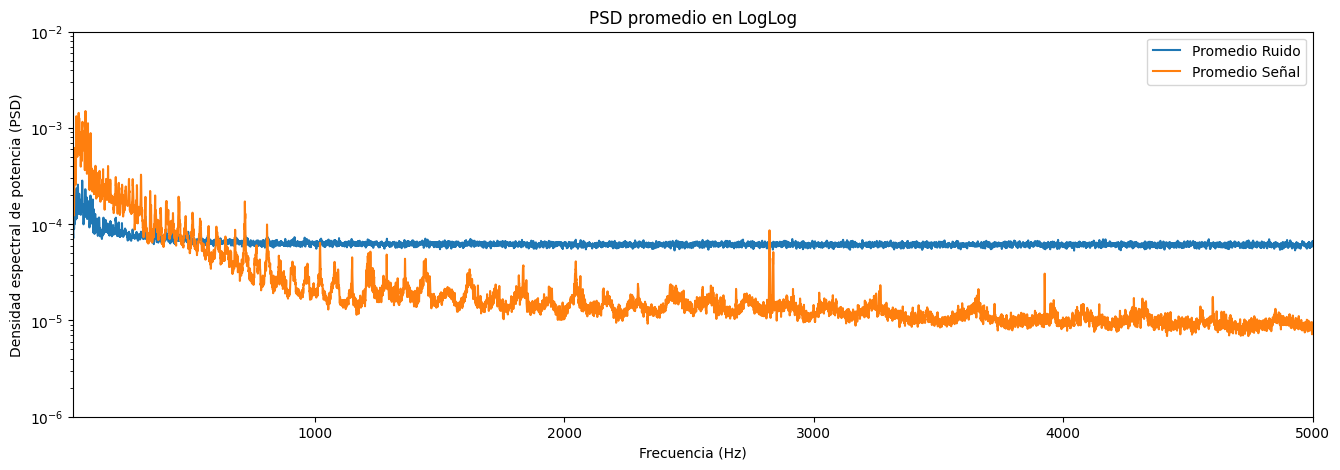

In [ ]:
#Gráfica logarítmica del promedio de audios etiquetados
psd_log_mean()

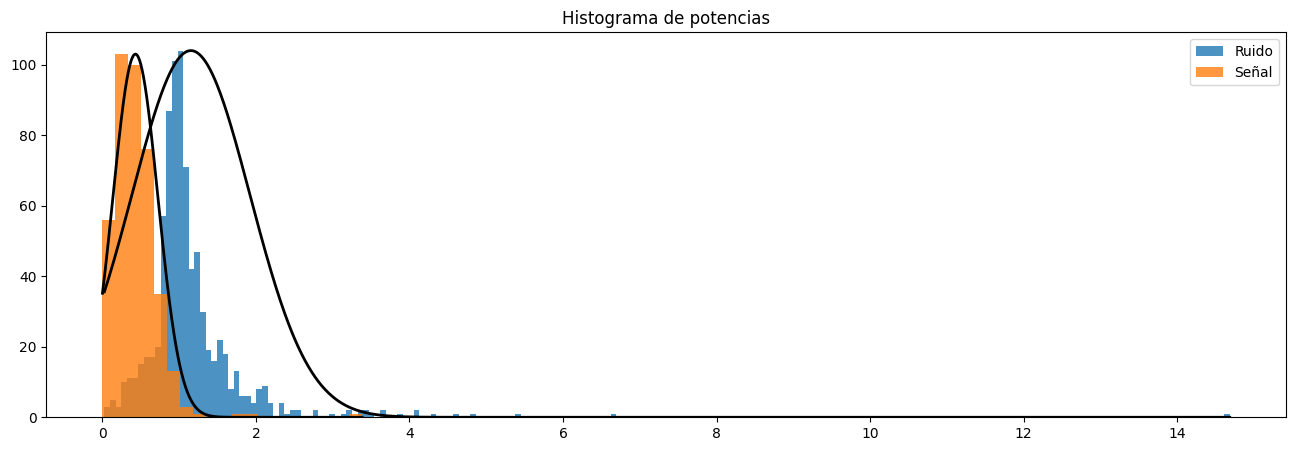

In [ ]:
"""
Hallamos la potencia de cada señal en base a sus etiquetas
y graficamos el histograma de las potencias con sus curvas
gaussianas aproximadas
"""
pot0 = pot(A0_trans)
pot1 = pot(A1_trans)
hist()

#Espectrograma

In [ ]:
f, t, espectros = espectrograma(M_audios)

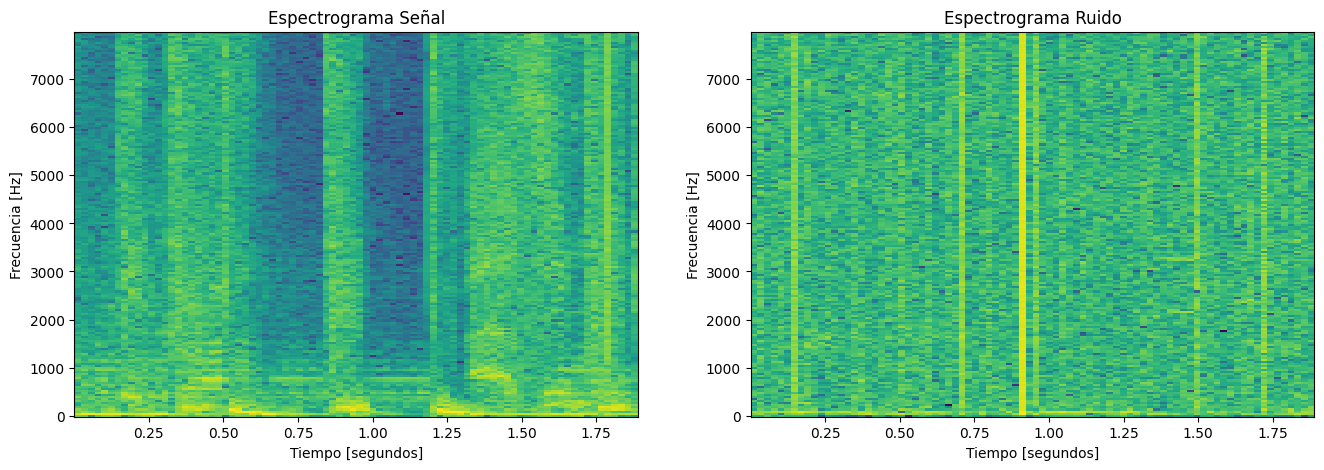

In [ ]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.pcolormesh(t, f, espectros[232])
plt.title('Espectrograma Señal')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [segundos]')

plt.subplot(1,2,2)
plt.pcolormesh(t, f, espectros[0])
plt.title('Espectrograma Ruido')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [segundos]')

plt.show()

#Keras Tuner

In [ ]:
!pip install keras-tuner --upgrade
import keras_tuner
import keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
from keras import layers
from keras_tuner.tuners import RandomSearch

In [ ]:
images = espectros/255.0
labels = df['Etiqueta']
labels = np.array(labels)

train_images = images[:844]
train_labels = labels[:844]
val_images = images[844:1044]
val_labels = labels[844:1044]
test_images = images[1044:]
test_labels = labels[1044:]

In [ ]:
train_images = np.stack((train_images,)*3, axis=-1)
val_images = np.stack((val_images,)*3, axis=-1)
test_images = np.stack((test_images,)*3, axis=-1)

In [ ]:
def build_model(hp):
    model = keras.Sequential()

    # Add Conv2D layer with tunable filters and kernel size
    model.add(keras.layers.Conv2D(
            filters=hp.Int('filters', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('kernel_size', values=[3, 5]),
            activation='relu',
            input_shape = (84, 186, 3)
            ))

    # Optional: Add a pooling layer to reduce the spatial dimensions
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=32, max_value=512, step=32),
            # Tune the activation function to use.
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )
    )
    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation="sigmoid"))
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

build_model(keras_tuner.HyperParameters())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Sequential name=sequential, built=True>

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='loss',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=2,  # Number of times to repeat each trial for more reliable results
    directory='my_dir',
    project_name='binary_classification'
)

In [ ]:
import shutil
# Eliminar el directorio donde se almacenan los resultados de la búsqueda
# shutil.rmtree('my_dir', ignore_errors=True)

In [ ]:
tuner.search(train_images, train_labels, epochs=5, validation_data=(val_images, val_labels))

Trial 5 Complete [00h 02m 48s]
loss: 0.6073295176029205

Best loss So Far: 0.2438950091600418
Total elapsed time: 00h 23m 05s


In [ ]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)

# Summary of the best model
model = best_model[0]

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 82, 184, 64)         │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 41, 92, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 241408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 352)                 │      84,975,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             353 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,978,113 (324.17 MB)

 Trainable params: 84,978,113 (324.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hps = tuner.get_best_hyperparameters()
hps[0].values

{'filters': 64,
 'kernel_size': 3,
 'units': 352,
 'activation': 'tanh',
 'dropout': False,
 'lr': 0.0002551564182173019}

In [ ]:
model.save('best_model.keras')

#Predicción

In [ ]:
from keras.models import load_model

# Load the model from the 'saved_model' directory
model = load_model('best_model.keras')

In [ ]:
pred_labels = model.predict(test_images)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


In [ ]:
pred_labels = np.round(pred_labels)
pred_labels = pred_labels.flatten()

In [ ]:
correct = 0
for i in range(len(pred_labels)):
  if pred_labels[i] == test_labels[i]:
    correct += 1
print(correct/len(pred_labels))

0.9440993788819876
